# Step 2a: Filtering en-route

## Import required libraries

In [1]:
import glob
import polars as pl
import pandas as pd
import numpy as np

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from multiprocessing import Pool
from traffic.core import Traffic, Flight

## Retrieve Preprocessed Data

In [2]:
files = glob.glob('/store/fusg/VT1/trajectory_data/*.parquet')

df = pl.read_parquet(files).to_pandas()
trajs = Traffic(df)
print(f"Total preprocessed Flights: {len(trajs)}")

Total preprocessed Flights: 379409


## Filter en-route trajectories

In [6]:
# def is_noisy(seg: Flight, change_frac_thresh: float = 0.15) -> bool:
#     """
#     Returns True if more than `change_frac_thresh` of consecutive
#     altitude steps are nonzero (i.e. a quantisation jump).
#     """
#     alt = seg.data["altitude"].to_numpy()
#     if len(alt) < 2:
#         return False
#     jumps = np.abs(np.diff(alt))
#     frac = np.count_nonzero(jumps) / jumps.size
#     return frac > change_frac_thresh

def filter_enroute_segments(
    f: Flight,
    min_altitude: int = 19500,
    min_length: int = 72,
    max_interp_gap: int = 2,
):
    if f.data["typecode"].isna().any():
        return []

    numeric = ["latitude","longitude","track",
               "altitude","groundspeed","vertical_rate"]
    cols = ["timestamp","icao24","flight_id", "callsign", "typecode"] + numeric
    df = f.data[cols].copy()

    df["timestamp"] = pd.to_datetime(df["timestamp"]).dt.floor("s")

    df = (df
          .set_index("timestamp")
          .sort_index()
          .resample("1s")
          .asfreq())

    df["icao24"]    = df["icao24"].ffill().bfill()
    df["flight_id"] = df["flight_id"].ffill().bfill()
    df["callsign"] = df["callsign"].ffill().bfill()

    df[numeric] = df[numeric].interpolate(
        method="linear",
        limit=max_interp_gap,
        limit_direction="both"
    )

    df = df.dropna(subset=numeric)
    # if is_noisy(f, change_frac_thresh=0.25):
    #     return []

    df = df[df["altitude"] >= min_altitude]
    if df.empty:
        return []
    
    alt = df["altitude"].to_numpy()
    if len(alt) > 1:
        if np.max(np.abs(np.diff(alt))) > 75:
            return []

    en = Flight(df.reset_index(), callsign=f.flight_id)
    segments = en.split(1,"s")

    return [seg for seg in segments if len(seg.data) >= min_length]

def get_all_enroute_segments(trajs, n_processes=48):
    with Pool(n_processes) as pool:
        for result in tqdm(pool.imap_unordered(filter_enroute_segments, trajs), total=len(trajs), desc="Extracting enroute segments"):
            for seg in result:
                yield seg

t_enroute = Traffic.from_flights(get_all_enroute_segments(trajs))
print(f"Total enroute segments: {len(t_enroute)}")

Extracting enroute segments:   0%|          | 0/379409 [00:04<?, ?it/s]

Total enroute segments: 180519


In [19]:
def filter_enroute_segments(f: Flight, min_altitude: int = 19500, min_length: int = 72, gap: int = 1):
    if f.data["typecode"].isna().any():
        return []

    numeric_columns = ["latitude", "longitude", "track", "altitude", "groundspeed", "vertical_rate"]
    df = f.data[numeric_columns]

    df_clean = df.dropna(how='any')
    if df_clean.empty:
        return []
    if (df_clean == 0).all().any():
        return []
    if df_clean["altitude"].max() < min_altitude:
        return []

    enroute = f.query(f"altitude >= {min_altitude}")
    if enroute is None or enroute.data.empty:
        return []

    enroute.data = enroute.data.sort_values("timestamp")
    segments = enroute.split(gap, 's')

    return [seg for seg in segments if len(seg.data) >= min_length]

def get_all_enroute_segments(trajs, n_processes=48):
    with Pool(n_processes) as pool:
        for result in tqdm(pool.imap_unordered(filter_enroute_segments, trajs), total=len(trajs), desc="Extracting en-route segments"):
            for seg in result:
                yield seg

t_enroute = Traffic.from_flights(get_all_enroute_segments(trajs))
print(f"Total en-route segments: {len(t_enroute)}")

Extracting en-route segments:   0%|          | 0/379409 [00:04<?, ?it/s]

Total en-route segments: 192216


## Examining Aircraft typecode

In [31]:
n = 1500

# Prepare data
typecodes = []
for flight in t_enroute:
    if not flight.data.empty and 'typecode' in flight.data.columns:
        tc = flight.data['typecode'].iloc[0]
        if pd.notna(tc):
            typecodes.append(tc)

df_typecodes = pd.DataFrame({'typecode': typecodes})
counts = df_typecodes['typecode'].value_counts()
frequent_types = counts[counts > n].index.tolist()

counts = counts[counts > n].sort_values(ascending=False)
print(f"Frequent typecodes (count > {n}):", frequent_types)

Frequent typecodes (count > 1500): ['A320', 'B738', 'A319', 'A20N', 'A321', 'B38M', 'BCS3', 'A21N', 'B77W', 'E190', 'B789', 'A333', 'E195', 'A359', 'PC12', 'BCS1']


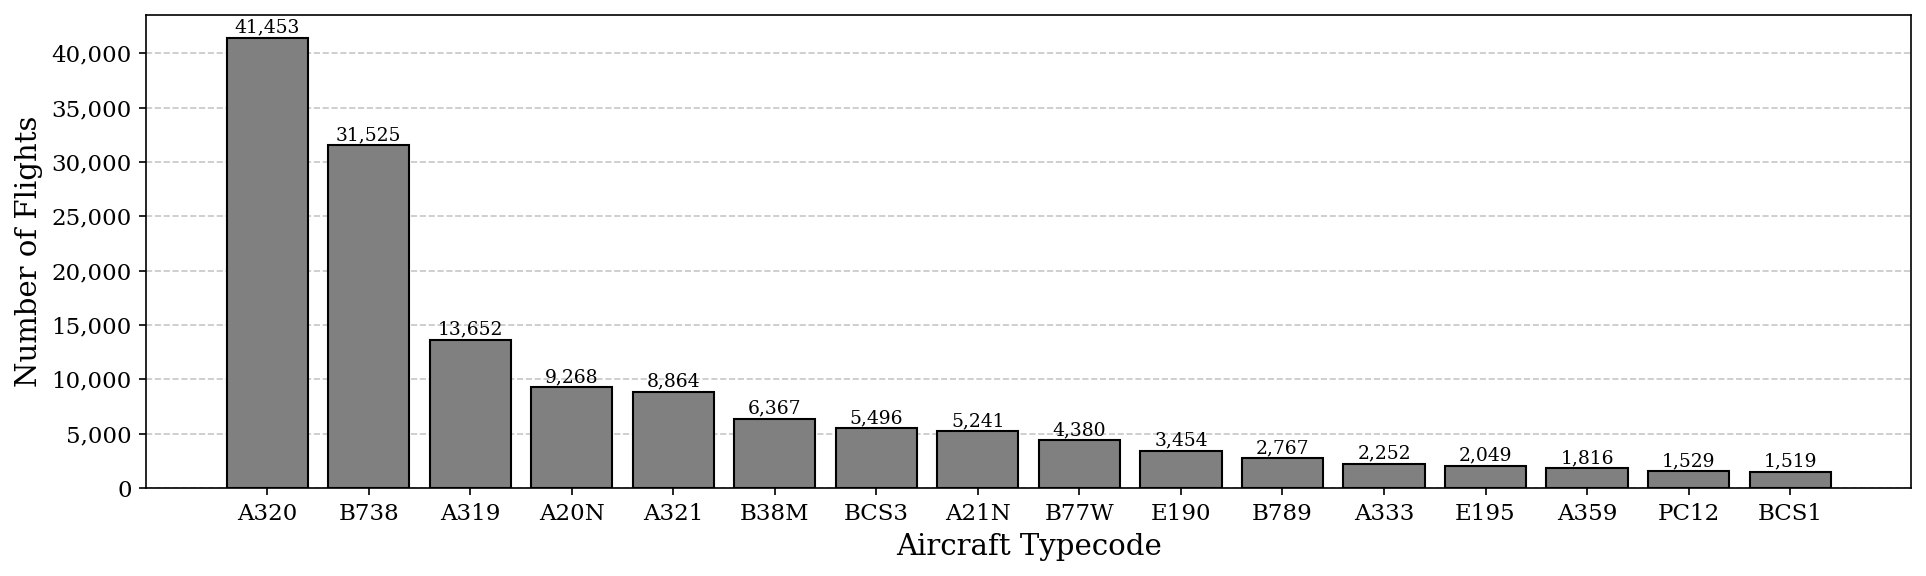

In [32]:
plt.rcParams.update({
    'text.usetex': False,
    'font.family': 'serif',
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'figure.dpi': 150
})

# Create figure
fig, ax = plt.subplots(figsize=(13, 4))
bars = ax.bar(counts.index, counts.values, color='gray', edgecolor='black')
ax.set_axisbelow(True)
ax.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:,}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 0.5),
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=9)

import matplotlib.ticker as mticker
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

# Add labels and title
ax.set_xlabel('Aircraft Typecode')
ax.set_ylabel('Number of Flights')
#ax.set_title('Most Frequent Aircraft Typecodes')

plt.tight_layout()
plt.show()

## Further examination

In [ ]:
# Sanity checks for the filtered en-route Traffic --------------------------------
min_len   = 72          # 12 s + 60 s @ 1 Hz
gap_limit = 1           # after interpolation no gap > 1 s should remain

bad_len   = []
bad_gap   = []
bad_alt   = []

for seg in tqdm(t_enroute_clean, desc="Validating segments"):
    df = seg.data.set_index("timestamp").sort_index()

    if len(df) < min_len:
        bad_len.append(seg)  # store object, not just callsign

    max_gap = df.index.to_series().diff().dt.total_seconds().fillna(1).max()
    if max_gap > gap_limit:
        bad_gap.append(seg)  # store Flight object

    if df["altitude"].min() < 19500:
        bad_alt.append(seg)

# -------------------------------------------------------------------------------
print(f"Total segments        : {len(t_enroute_clean):,}")
print(f"Segments < {min_len} rows : {len(bad_len)}")
print(f"Gaps > {gap_limit}s       : {len(bad_gap)}")
print(f"Alt < 19 500 ft         : {len(bad_alt)}")

assert not bad_len, f"Found {len(bad_len)} segments shorter than {min_len}"
assert not bad_gap, f"Found {len(bad_gap)} segments with gaps >1 s"
assert not bad_alt, f"Found {len(bad_alt)} segments with alt < FL195"
print("All sanity checks passed!")

Validating segments:   0%|          | 0/180519 [00:00<?, ?it/s]

Total segments        : 180,519
Segments < 72 rows : 0
Gaps > 1s       : 5
Alt < 19 500 ft         : 0


AssertionError: Found 5 segments with gaps >1 s

In [23]:
from tqdm import tqdm
from traffic.core import Traffic

# Re-build only the segments that pass all three sanity checks:
final_segs = []
min_len, gap_limit = 72, 1

for seg in tqdm(t_enroute_clean, desc="Final sanity filtering"):
    df = seg.data.set_index("timestamp").sort_index()

    # 1) length check
    if len(df) < min_len:
        continue

    # 2) gap check
    max_gap = df.index.to_series().diff().dt.total_seconds().fillna(0).max()
    if max_gap > gap_limit:
        continue

    # 3) altitude check
    if df["altitude"].min() < 19500:
        continue

    # if we reach here, all checks passed
    final_segs.append(seg)

# Build the final Traffic object
t_enroute_final = Traffic.from_flights(final_segs)
print(f"Original count: {len(t_enroute_clean)}")
print(f"Final count   : {len(t_enroute_final)}  (dropped {len(t_enroute_clean)-len(t_enroute_final)} segments)")

Final sanity filtering: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180519/180519 [04:21<00:00, 690.13it/s]


Original count: 180519
Final count   : 180514  (dropped 5 segments)


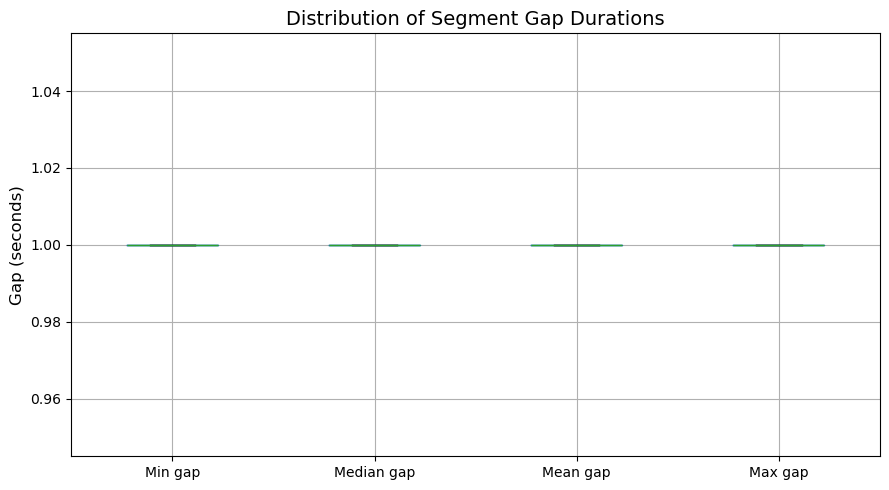

In [24]:
# Compute per-segment gap statistics
max_gaps = []
mean_gaps = []
median_gaps = []
min_gaps = []

for seg in t_enroute_final:
    df = seg.data.set_index("timestamp").sort_index()
    gaps = df.index.to_series().diff().dt.total_seconds().dropna()
    if gaps.empty:
        continue
    max_gaps.append(gaps.max())
    mean_gaps.append(gaps.mean())
    median_gaps.append(gaps.median())
    min_gaps.append(gaps.min())

# Prepare DataFrame for plotting
stats_df = pd.DataFrame({
    'Min gap': min_gaps,
    'Median gap': median_gaps,
    'Mean gap': mean_gaps,
    'Max gap': max_gaps
})

# Plot boxplot
fig, ax = plt.subplots(figsize=(9, 5))
stats_df.boxplot(ax=ax)
ax.set_title('Distribution of Segment Gap Durations', fontsize=14)
ax.set_ylabel('Gap (seconds)', fontsize=12)
ax.tick_params(labelsize=10)
plt.tight_layout()
plt.show()

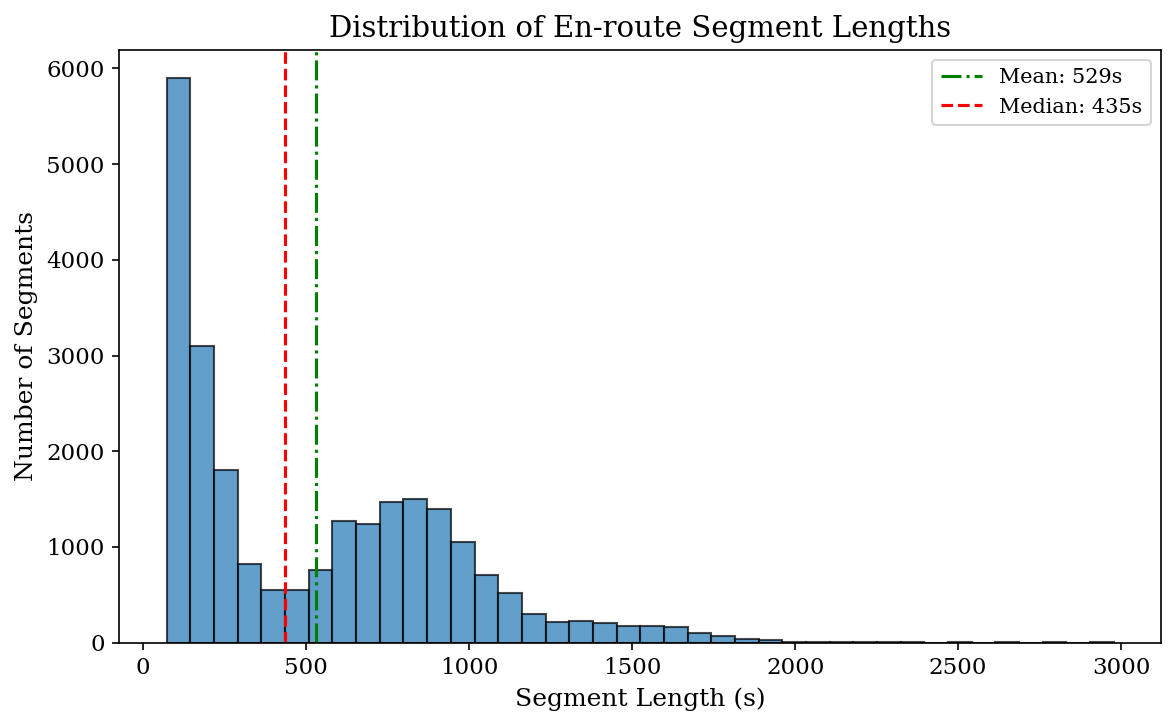

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter

lengths = np.array([len(seg.data) for seg in t_enroute])

mean_len = lengths.mean()
median_len = np.median(lengths)

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(lengths, bins=40, edgecolor='black', alpha=0.7)
ax.axvline(mean_len, color='green', linestyle='-.', linewidth=1.5, label=f'Mean: {mean_len:.0f}s')
ax.axvline(median_len, color='red', linestyle='--', linewidth=1.5, label=f'Median: {median_len:.0f}s')

ax.set_xlabel('Segment Length (s)', fontsize=12)
ax.set_ylabel('Number of Segments', fontsize=12)
ax.set_title('Distribution of En-route Segment Lengths', fontsize=14)
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)}'))

ax.legend(fontsize=10)
plt.tight_layout()
plt.show()

In [188]:
# Now count how many segments are flagged:
noisy_flags = [is_noisy(seg, change_frac_thresh=0.05) for seg in t_enroute]
n_noisy = sum(noisy_flags)
n_total = len(t_enroute)

print(f"Noisy segments: {n_noisy} / {n_total} "
      f"({100 * n_noisy/n_total:.1f}%)")

Noisy segments: 31346 / 56599 (55.4%)


Index : 149104


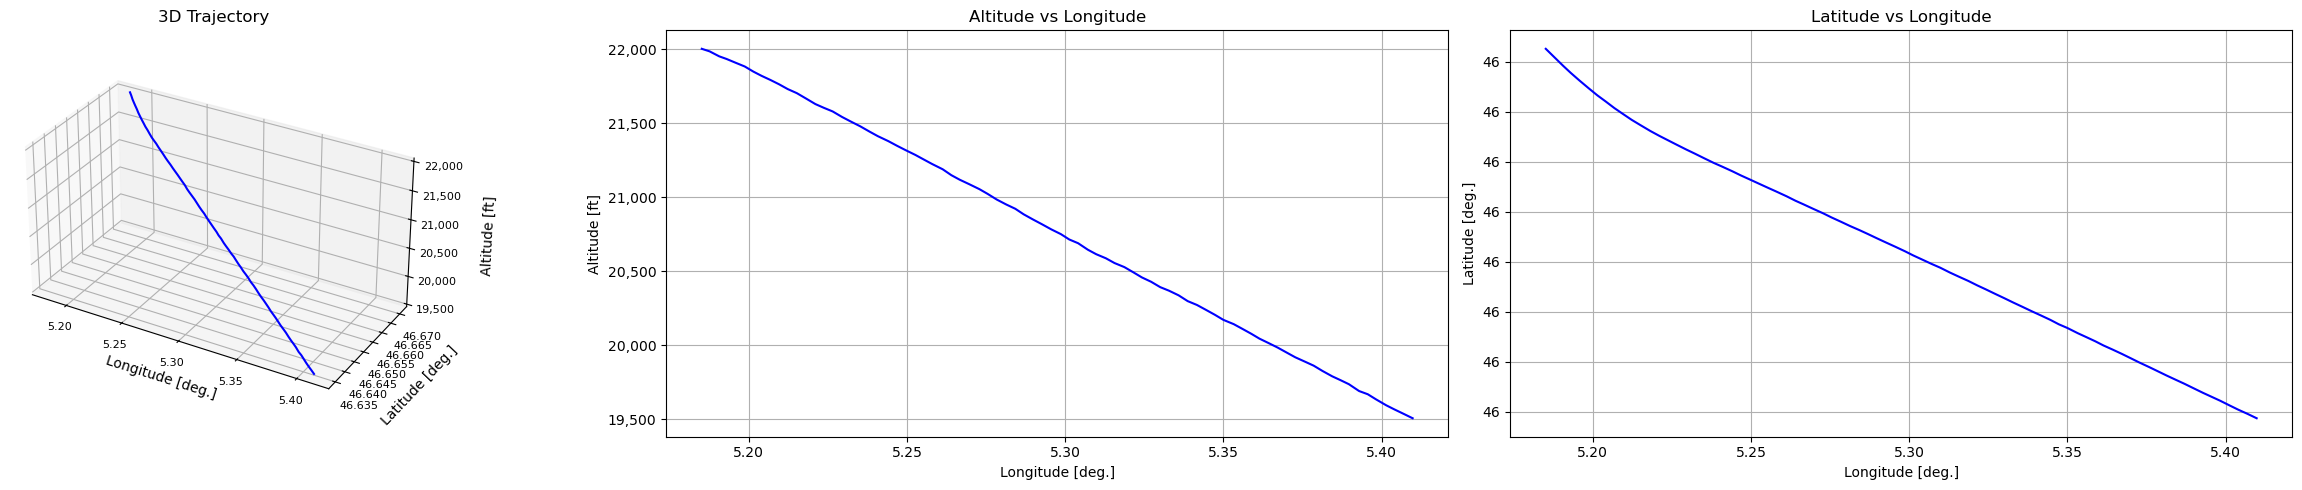

In [27]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D
import random
idx = random.randint(0, len(t_enroute) - 1)
#idx = 455
#idx = 455
print(f"Index : {idx}")
# 455 is pure noise

seg = t_enroute[idx]
df = seg.data

lat = df["latitude"].to_numpy()
lon = df["longitude"].to_numpy()
alt = df["altitude"].to_numpy()

fig = plt.figure(figsize=(25, 5))

# === 1) 3D Trajectory ===
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax1.plot(lon, lat, alt, 'b-', label="Trajectory")
ax1.set_title("3D Trajectory", fontsize=12)
ax1.set_xlabel("Longitude [deg.]", fontsize=10)
ax1.set_ylabel("Latitude [deg.]", fontsize=10)
ax1.set_zlabel("Altitude [ft]", fontsize=10, labelpad=10)
ax1.zaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}"))
ax1.tick_params(labelsize=8)
ax1.set_box_aspect([2, 1, 1])  # [x, y, z] proportions

# === 2) Altitude vs Longitude ===
ax2 = fig.add_subplot(1, 3, 2)
ax2.plot(lon, alt, 'b-')
ax2.set_xlabel("Longitude [deg.]", fontsize=10)
ax2.set_ylabel("Altitude [ft]", fontsize=10)
ax2.set_title("Altitude vs Longitude", fontsize=12)
ax2.grid(True)
ax2.tick_params(labelsize=10)
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}"))

# === 3) Latitude vs Longitude (Ground Track) ===
ax3 = fig.add_subplot(1, 3, 3)
ax3.plot(lon, lat, 'b-')
ax3.set_xlabel("Longitude [deg.]", fontsize=10)
ax3.set_ylabel("Latitude [deg.]", fontsize=10)
ax3.set_title("Latitude vs Longitude", fontsize=12)
ax3.grid(True)
ax3.tick_params(labelsize=10)
ax3.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}"))

plt.tight_layout()
plt.show()

In [23]:
def check_zero_altitude_change_on_tenroute(t_enroute):
    """
    Iterate over the en-route Traffic object and report
    how many segments have zero net altitude change.
    """
    zero_span = 25
    total     = len(t_enroute)  # assumes Traffic is iterable / supports len()

    for seg in t_enroute:
        alts = seg.data["altitude"].to_numpy()
        if alts.max() - alts.min() == 0:
            zero_span += 1

    print(f"Total segments          : {total}")
    print(f"Zero-altitude-change    : {zero_span} "
          f"({zero_span/total*100:.2f}%)")
    print(f"Non-zero-altitude-change: {total-zero_span} "
          f"({(total-zero_span)/total*100:.2f}%)")

# Example usage, right after you build t_enroute:
check_zero_altitude_change_on_tenroute(t_enroute)


Total segments          : 192216
Zero-altitude-change    : 24224 (12.60%)
Non-zero-altitude-change: 167992 (87.40%)


Altitude-span statistics (ft):
  Min   : 0.0
  25th  : 128.0
  Median: 128.0
  75th  : 192.0
  Max   : 32896.0


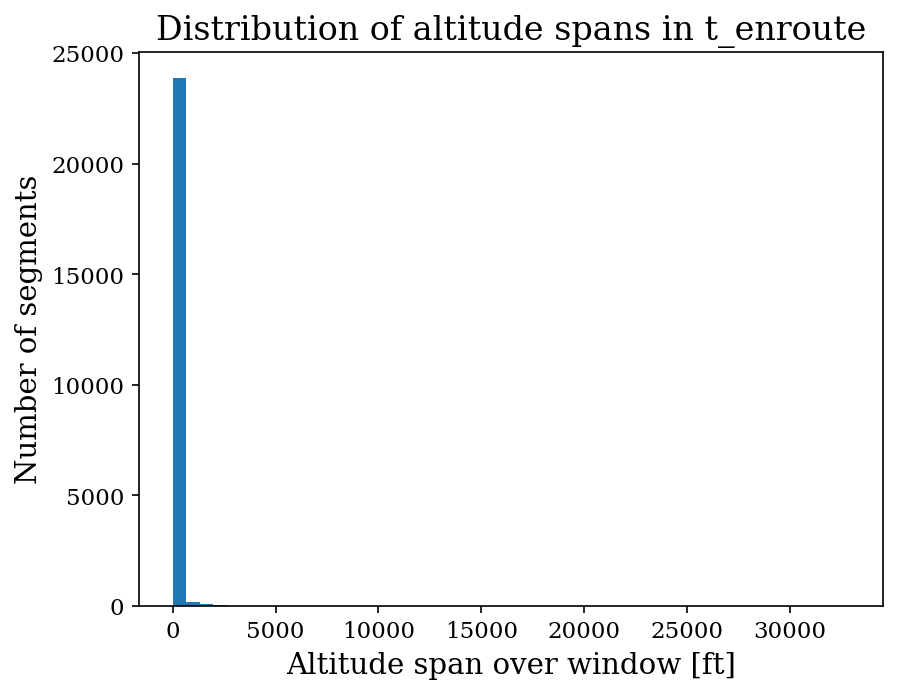

In [44]:
import numpy as np

# Compute span (max–min) for each segment
spans = np.array([
    np.ptp(seg.data["vertical_rate"].to_numpy())  # peak-to-peak = max-min
    for seg in t_enroute
])

# Basic statistics
print("Altitude-span statistics (ft):")
print(f"  Min   : {spans.min():.1f}")
print(f"  25th  : {np.percentile(spans, 25):.1f}")
print(f"  Median: {np.percentile(spans, 50):.1f}")
print(f"  75th  : {np.percentile(spans, 75):.1f}")
print(f"  Max   : {spans.max():.1f}")

# (Optional) plot a quick histogram if you like
import matplotlib.pyplot as plt
plt.hist(spans, bins=50)
plt.xlabel("Altitude span over window [ft]")
plt.ylabel("Number of segments")
plt.title("Distribution of altitude spans in t_enroute")
plt.show()


In [24]:
# Filter out fully flat segments
dynamic_segs = [
    seg
    for seg in t_enroute
    if np.ptp(seg.data["altitude"]) > 100 # peak-to-peak > 0
]
print(f"Dynamic segments: {len(dynamic_segs)} / {len(t_enroute)} "
      f"({len(dynamic_segs)/len(t_enroute)*100:.1f}%)")


Dynamic segments: 120374 / 192216 (62.6%)


In [43]:
# How many flat-altitude segments still report nonzero vertical_rate?
vr_nonzero = sum(
    1
    for seg in t_enroute
    if np.ptp(seg.data["altitude"]) == 0
    and seg.data["vertical_rate"].abs().max() > 0
)
print(f"Flat-altitude but nonzero vertical_rate segments: {vr_nonzero}")


Flat-altitude but nonzero vertical_rate segments: 16568


## Final save

In [38]:
# Save t_enroute as traff filtered in store cluster as well as frequent typecodes
version = "v4"

# v1 : original, no gap interpolation
# v2 : remove change > 0.25, gap interpolation
# v3 : no change removed, gap interpolation

# t_enroute_final.data.reset_index(drop=True).to_parquet(
#     f"/store/fusg/VT1/training/{version}/traffic_enroute_filtered.parquet"
# )

# 1) Turn your final Traffic back into a pandas DataFrame
df = t_enroute_final.data

# 2) Drop any unwanted index columns (like '__index_level_0__')
df = df.reset_index(drop=True)
df = df.drop(columns=[c for c in df.columns if c.startswith('__index_level_')])

# 3) Write via pandas, which promotes string columns to large strings
out_path = f"/store/fusg/VT1/training/{version}/traffic_enroute_filtered.parquet"
df.to_parquet(out_path, index=False)

np.save(f"/store/fusg/VT1/training/{version}/frequent_typecodes.npy", frequent_types)

In [35]:
t_enroute_final.data.columns

Index(['timestamp', 'icao24', 'flight_id', 'callsign', 'typecode', 'latitude',
       'longitude', 'track', 'altitude', 'groundspeed', 'vertical_rate'],
      dtype='object')